#Geospatial processing with Spark Structured Streaming and GeoMesa

Scenario:
* 100 drones fly and report every second their GPS coordinates.
* *Geofencing*: Drones are not allowed to leave US territory. If a drone leaves that limit, we must detect it immediately and flag the drone.
* *Nearest object tracking*: If a drone suffers a malfunction, it must immediately seek permission to land at the nearest airport. For that purpose, we need to constantly track the nearest airport for each drone.

In our simulated setup:
* At the start, 100 drones are all spawned at a single location within the United States.
* Each second, they move in a random direction (brownian motion).
* Each second, they report their coordinates as an event.

We will import datasets of US borders and of airport locations, and show how to use stream processing to generate a near-real time view of the processed data.

## Download and process US borders

We download country border shapes from [Natural Earth Data](http://www.naturalearthdata.com), a public domain dataset.

In [4]:
%sh curl -fLO https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip

% Total % Received % Xferd Average Speed Time Time Time Current
 Dload Upload Total Spent Left Speed

 0 0 0 0 0 0 0 0 --:--:-- --:--:-- --:--:-- 0
 0 0 0 0 0 0 0 0 --:--:-- --:--:-- --:--:-- 0
 0 0 0 0 0 0 0 0 --:--:-- 0:00:01 --:--:-- 0

 0 0 0 0 0 0 0 0 --:--:-- 0:00:01 --:--:-- 0
100 285 100 285 0 0 193 0 0:00:01 0:00:01 --:--:-- 3131

100 192k 100 192k 0 0 86090 0 0:00:02 0:00:02 --:--:-- 86090

In [5]:
%sh unzip -o ne_110m_admin_0_countries.zip

Archive: ne_110m_admin_0_countries.zip
 inflating: ne_110m_admin_0_countries.README.html 
 extracting: ne_110m_admin_0_countries.VERSION.txt 
 extracting: ne_110m_admin_0_countries.cpg 
 inflating: ne_110m_admin_0_countries.dbf 
 inflating: ne_110m_admin_0_countries.prj 
 inflating: ne_110m_admin_0_countries.shp 
 inflating: ne_110m_admin_0_countries.shx

The data is in Shapefile format. For a pure Python solution we use the *geopandas* module to parse the Shapefile.

In [7]:
dbutils.library.installPyPI("geopandas", version="0.5.1")
dbutils.library.installPyPI("descartes", version="1.1.0")

Out[ 3 ]: True

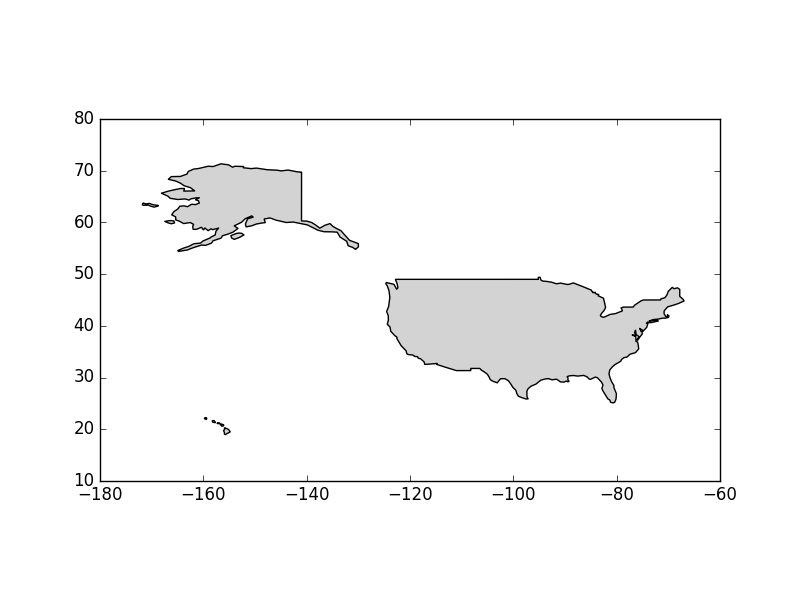

In [8]:
import geopandas
import numpy as np
import matplotlib.pyplot as plt

country_shapes = geopandas.read_file("ne_110m_admin_0_countries.shp")
us_shapes = country_shapes[country_shapes.ADM0_A3_IS == "USA"]

fig, ax = plt.subplots()
base = us_shapes.plot(ax=ax, color='lightgray')
display(fig)

We store the US geometry as a 1x1 Spark temporary view, in order to make it available to Scala.

In [10]:
from pyspark.sql import Row

us_borders = us_shapes.geometry.iloc[0]
spark.createDataFrame([Row(us_borders.wkt)], "geometry string").createOrReplaceTempView("us_borders")

## Download and process airport information

We download airport geolocation data from [OpenFlights](https://github.com/jpatokal/openflights).

In [12]:
%sh curl -fo airports.dat https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat

% Total % Received % Xferd Average Speed Time Time Time Current
 Dload Upload Total Spent Left Speed

 0 0 0 0 0 0 0 0 --:--:-- --:--:-- --:--:-- 0
100 1100k 100 1100k 0 0 2313k 0 --:--:-- --:--:-- --:--:-- 2317k

In [13]:
import pandas as pd
airports = pd.read_csv("airports.dat", names=["Airport_ID", "Name", "City", "Country", "IATA", "ICAO", "Latitude", "Longitude", "Altitude", "Timezone", "DST", "Tz", "Type", "Source"], na_values="\\N")
spark.createDataFrame(airports).createOrReplaceTempView("airports")
airports.head(3)

,Airport_ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.08169,145.391998,5282,10.0,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.20708,145.789001,20,10.0,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.82679,144.296005,5388,10.0,U,Pacific/Port_Moresby,airport,OurAirports


In [14]:
table("airports").count()

Out[ 8 ]: 7698

## Creating the streaming job

We collect the data on US borders to apply geofencing, as well as the airport geolocations.

In [17]:
%scala
import org.apache.spark.sql.functions._

val us_borders = table("us_borders").collect()(0)(0)

case class Airport(ICAO:String, Longitude:Double, Latitude:Double)
val airports = table("airports").select("ICAO", "Longitude", "Latitude").as[Airport].collect()


import org.apache.spark.sql.functions._
us_borders: Any = MULTIPOLYGON (((-122.84 49.00000000000011, -120 49.00000000000011, -117.03121 49, -116.04818 49, -113 49, -110.05 49, -107.05 49, -104.04826 48.99986000000007, -100.65 49.00000000000011, -97.2287200000048 49.0007, -95.15906950917206 49, -95.15609000000001 49.38425000000001, -94.81758000000002 49.38905, -94.64 48.84, -94.32914000000001 48.67074, -93.63087000000002 48.60926000000001, -92.61000000000001 48.44999999999993, -91.64 48.14, -90.83 48.27, -89.60000000000002 48.0100000000001, -89.27291744663665 48.01980825458281, -88.37811418328671 48.30291758889371, -87.43979262330028 47.94, -86.46199083122826 47.553338019392, -85.65236324740341 47.22021881773051, -84.8760798815149 46.90008331968238, -84.77923824739992 46.63710195574902, -84.54374874544584 46.53868419044915, -84.60490000000004 46.43959999999998, -84.33670000000001 46.40877, -84.14211951367341 46.51222585711571, -84.09185126416151 46.27541860613826, -83.89076534700574 46.11692698829901, -83.61613094759059 46.11692698829901, -83.46955074739469 45.99468638771253, -83.59285071484311 45.81689362241252, -82.55092464875821 45.34751658790543, -82.33776312543114 44.44000000000005, -82.13764238150395 43.57108755143997, -82.42999999999999 42.98, -82.90000000000001 42.43, -83.12 42.08, -83.14199968131264 41.97568105729287, -83.02981014680699 41.83279572200598, -82.69008928092023 41.67510508886733, -82.43927771679159 41.67510508886733, -81.27774654816716 42.20902598730682, -80.24744767934794 42.36619985612255, -78.93936214874375 42.86361135514798, -78.92 42.965, -79.01000000000001 43.27, -79.17167355011186 43.46633942318426, -78.72027991404235 43.62508942318493, -77.7378850979577 43.62905558936328, -76.82003414580558 43.62878428809375, -76.50000000000001 44.01845889375865, -76.375 44.09631, -75.31821000000001 44.81645, -74.86700000000002 45.0004800000001, -73.34783 45.00738, -71.50506 45.0082, -71.405 45.255, -71.08482000000004 45.30524000000014, -70.66 45.46, -70.30500000000001 45.915, -69.99997 46.69307, -69.237216 47.447781, -68.90500000000003 47.18500000000006, -68.23444000000001 47.35485999999997, -67.79046000000001 47.06636, -67.79134000000001 45.70281000000001, -67.13741 45.13753, -66.96465999999998 44.80970000000013, -68.03251999999998 44.3252, -69.05999999999995 43.98000000000008, -70.11616999999995 43.68405000000013, -70.64547563341102 43.09023834896402, -70.81488999999999 42.86529999999993, -70.82499999999999 42.33499999999998, -70.49499999999995 41.80500000000001, -70.07999999999998 41.78000000000003, -70.185 42.1450000000001, -69.88496999999995 41.92283000000009, -69.96502999999996 41.63717000000014, -70.63999999999999 41.47500000000002, -71.12039000000004 41.49445000000014, -71.8599999999999 41.32000000000005, -72.29500000000002 41.26999999999998, -72.87643000000003 41.22065000000003, -73.71000000000004 40.93110235165449, -72.24125999999995 41.11948000000012, -71.94499999999988 40.93000000000006, -73.34499999999997 40.63000000000005, -73.98200000000003 40.62799999999993, -73.95232499999997 40.75075000000004, -74.25671 40.47351000000003, -73.96243999999996 40.42763000000002, -74.17838 39.70925999999997, -74.90603999999996 38.93954000000002, -74.98041000000001 39.19640000000004, -75.20001999999999 39.2484500000001, -75.52805000000001 39.49850000000009, -75.31999999999999 38.96000000000004, -75.07183476478986 38.78203223017925, -75.05672999999996 38.40412000000009, -75.37746999999996 38.01551000000001, -75.94022999999999 37.21689000000009, -76.03126999999995 37.25659999999999, -75.72204999999985 37.93705000000011, -76.23286999999999 38.31921499999999, -76.35000000000002 39.14999999999998, -76.54272499999996 38.71761500000008, -76.32933000000003 38.08326000000005, -76.98999793161352 38.23999176691336, -76.30161999999996 37.91794499999992, -76.25873999999999 36.96640000000008, -75.97179999999997 36.89726000000002, -75.86803999999989 36.55125000000004, -75.72748999999999 35.55074000000013, -76.36318 34.80854000000011

We define a UDF that computes the nearest airport to a given point. The airport data is broadcast in order to be available to our UDF.

In [19]:
%scala
import org.geotools.referencing.GeodeticCalculator

val broadcastedAirports = sc.broadcast(airports) 

val nearest_airport = org.apache.spark.sql.functions.udf((x:Double, y:Double) => {
  val c = new GeodeticCalculator
  c.setStartingGeographicPoint(x, y)
  val airportDistances = broadcastedAirports.value.map(airport => {
    c.setDestinationGeographicPoint(airport.Longitude, airport.Latitude)
    (airport, c.getOrthodromicDistance)
  })
  val airportDistancesSorted = airportDistances.sortBy(_._2)
  airportDistancesSorted(0)._1.ICAO
})

// Example: show the nearest airports for the points at coordinates (0,0), (0,10) and (0,20)
display(spark.range(0, 30, step=10).select(nearest_airport(lit(0), $"id")))        

"UDF(0, id)"
FADW
DXMG
GATS


We define the function to be used with `mapGroupsWithState` (grouped by droneId). For each micro-batch, the function will receive an iterator of all events in the micro-batch for the given `droneId`. We simply store the data of the latest event as the current state for the drone.

In [21]:
%scala
import org.apache.spark.sql.streaming._

case class InputRow(droneId:String, timestamp:java.sql.Timestamp,
                     xMotion:Double, yMotion:Double)
case class DroneState(droneId:String, var timestamp:java.sql.Timestamp,
                      var x:Double, var y:Double)

def updateStateWithEvent(state:DroneState, input:InputRow):DroneState = {
  if (input.timestamp.compareTo(state.timestamp) < 0) {
    return state
  }
  state.timestamp = input.timestamp
  state.x += input.xMotion
  state.y += input.yMotion
  state.x = math.max(math.min(state.x, 180), -180)
  state.y = math.max(math.min(state.y, 90), -90)
  //return the updated state
  state
}

def updateAcrossEvents(device:String,
    inputs: Iterator[InputRow],
     oldState: GroupState[DroneState]):DroneState = {
     var state:DroneState = if (oldState.exists) oldState.get else DroneState(device,
       new java.sql.Timestamp(0L), -100, 40)
  for (input <- inputs) {
    state = updateStateWithEvent(state, input)
    oldState.update(state)
  }
  state
}

import org.apache.spark.sql.streaming._
defined class InputRow
defined class DroneState
updateStateWithEvent: (state: DroneState, input: InputRow)DroneState
updateAcrossEvents: (device: String, inputs: Iterator[InputRow], oldState: org.apache.spark.sql.streaming.GroupState[DroneState])DroneState

We create the stream processing job. The job uses the Spark rate generator to produces an endless series of integers. By taking the modulo 100, we generate an endless list (0...99,0...99,...) that represents our droneIds. We then generate a random motion value in each direction.

After apply our state mapping function, we use GeoMesa to compute the geofencing flag (whether each drone is within US boundaries), and apply our UDF to compute the nearest airport location. We output the result to an in-memory table for debugging.

Note: in-memory tables are meant for debugging use only. In this test setup, the in-memory table will grow indefinitely until the driver runs out of memory. In a production setup, consider streaming the data to a repository. For example, streaming to CosmosDB with the Upsert flag would store the latest state of each drone.

In [23]:
%scala

//GeoMesa setup
import org.apache.spark.sql.SQLTypes
import org.locationtech.geomesa.spark.jts._
SQLTypes.init(sqlContext) // Register custom Geometry types

spark
  .readStream
  .format("rate")
  .option("rowsPerSecond", "100")
  .load()
  .withColumn("droneId", pmod($"value", lit(2)))
  .selectExpr("value % 100 AS droneId", "timestamp",
              "randn() as xMotion", "randn() as yMotion")
  .as[InputRow]
  // group the state by drone
  .groupByKey(_.droneId)
  .mapGroupsWithState(GroupStateTimeout.NoTimeout)(updateAcrossEvents)
  .withColumn("geofenced", st_contains(st_geomFromWKT(lit(us_borders)), st_point($"x", $"y")))
  .withColumn("airport", nearest_airport($"x", $"y"))
  .writeStream
  .outputMode("update")
  .queryName("drone_data")
  .format("memory")
  .start()

import org.apache.spark.sql.SQLTypes
import org.locationtech.geomesa.spark.jts._
res1: org.apache.spark.sql.streaming.StreamingQuery = org.apache.spark.sql.execution.streaming.StreamingQueryWrapper@432418a9

We create a function to get the latest data for each drone from our in-memory table. If this produces no output, wait a few seconds for the streaming query to start producing data.

In [25]:
from geopandas import GeoDataFrame
from shapely.geometry import Point

def get_current_drone_positions():
  points = sql("""
  WITH latest_data AS (SELECT droneId AS droneId, max(timestamp) AS timestamp from drone_data GROUP BY droneId)
  SELECT * FROM drone_data
  JOIN latest_data USING (droneId, timestamp)
  """).toPandas()

  geometry = [Point(xy) for xy in zip(points.x, points.y)]
  points = points.drop(['x', 'y'], axis=1)
  crs = {'init': 'epsg:4326'}
  return GeoDataFrame(points, crs=crs, geometry=geometry)

get_current_drone_positions().head(3)

,droneId,timestamp,geofenced,airport,geometry
0,51,2019-07-23 11:26:13.195,False,CYBA,POINT (-115.6154667206981 51.75653556343912)
1,7,2019-07-23 11:26:12.755,False,MMIO,POINT (-100.8008211354561 24.7324083603536)
2,15,2019-07-23 11:26:12.835,False,CYYQ,POINT (-88.94409172278695 58.86526392061013)


Let's use *plotly* to represent this data as an interactive chart. Every time you rerun this call, the chart updates to show the latest data.

In [27]:
dbutils.library.installPyPI("plotly", version="4.0.0")

Out[ 10 ]: True

In [28]:
from plotly.offline import plot
import plotly.graph_objects as go
import numpy as np

gdf = get_current_drone_positions()

# See https://docs.azuredatabricks.net/user-guide/visualizations/plotly.html for more info on plotly usage in Databricks
p = plot(
  [
    go.Scattergeo(
        lon = gdf.geometry.x,
        lat = gdf.geometry.y,
        text = "Drone: " + gdf.droneId + ", nearest airport: " + gdf.airport,
        name = "Drones",
        marker = dict(
            size=10,
            color=np.where(gdf.geofenced, 'green', 'red'),
            line_width=0
        ),
    )
  ],
  output_type='div'
)

displayHTML(p)

Out[ 16 ]: 1